In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Run vs Pass classification Panthers
def build():
    network = keras.models.Sequential()
    network.add(Dense(182, activation = 'elu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(1.e-3)))
    network.add(Dense(52, activation = 'relu', kernel_regularizer=l2(1.e-3)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adam" ,metrics=['accuracy'])
    return network


#Data preparation for classification Panthers
def data_prep(data):
    y = data['PLAY TYPE']
    x = data.drop(columns = ['PLAY TYPE'])
    x = pd.get_dummies(x)
    y = y.apply(playtypetobinary)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    cols = ['DIST', 'YARD LN']
    for x in cols:
        mean = x_train[x].mean(axis=0)
        x_train[x] -= mean
        std = x_train[x].std(axis=0)
        x_train[x] /= std
        x_test[x] -= mean
        x_test[x] /= std
    return x_train, x_test, y_train, y_test

#Classification k-cross-validation
def cross_valid_reg(k, num_epochs, x_train, y_train, x_test, y_test):
    samples = len(x_train) // k
    val_history = []
    train_history = []
    for i in range(k):
        data = x_train[i * samples: (i + 1) * samples]
        targets = y_train[i * samples: (i + 1) * samples]
        partial_train_data = np.concatenate([x_train[:i * samples], x_train[(i + 1) * samples:]],axis=0)
        partial_train_targets = np.concatenate([y_train[:i * samples],y_train[(i + 1) * samples:]],axis=0)
        model = build()
        if i == 0:
            print('Input size: ', x_train.shape)
            print(model.summary())
        hist = model.fit(partial_train_data, partial_train_targets, validation_data=(data, targets),
                         epochs=num_epochs, batch_size=100, verbose=0)
        loss_history1 = hist.history['val_loss']
        loss_history2 = hist.history['loss']
        val_history.append(loss_history1)
        train_history.append(loss_history2)
        
    val_history = [np.mean([x[i] for x in val_history]) for i in range(num_epochs)]
    train_history = [np.mean([x[i] for x in train_history]) for i in range(num_epochs)]
    plt.figure(figsize=(12, 8))
    plt.rcParams.update({'font.size': 24})
    plt.plot(range(1, len(val_history) + 1), val_history)
    plt.plot(range(1, len(train_history) + 1), train_history)
    plt.xlabel('Epochs')
    plt.ylabel('loss_function')
    plt.legend(['Validation', 'Training'])
    plt.ylim([0.46,0.8])
    plt.savefig('PassPanthers1.png')
    plt.show()
    _,mae = model.evaluate(x_test, y_test)
    print('Accuracy of the network is ', mae)
    return model
    
def playtypetobinary(x):
    if x=='Run':
        x = 0
    else:
        x = 1
    return x

Input size:  (330, 16)
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 182)               3094      
_________________________________________________________________
dense_175 (Dense)            (None, 52)                9516      
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 53        
Total params: 12,663
Trainable params: 12,663
Non-trainable params: 0
_________________________________________________________________
None


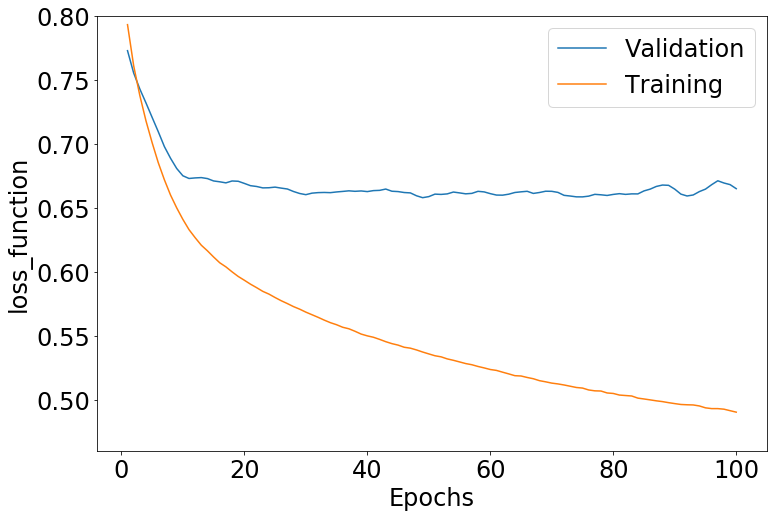

3/3 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.6867
Accuracy of the network is  0.6867470145225525
Guessing that every play is a run generates accuracy:  0.5484848484848485


In [34]:
#Panthers run vs pass classification
data = pd.read_csv("data/PanthersClass.csv")
x_train, x_test, y_train, y_test = data_prep(data)

#Benchmark
benchmark = y_train.value_counts(normalize = True)

model = cross_valid_reg(4, 100, x_train, y_train, x_test, y_test)
print('Guessing that every play is a run generates accuracy: ', benchmark[0])



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
3/3 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.6867


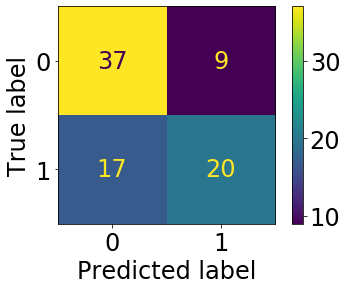

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model.predict_classes(x_test).tolist()))
model.evaluate(x_test, y_test)
disp.plot()
plt.savefig('PassPWConf1.png')